# Companies Analisys: exploring data of companing with same name

This notebook provides an exploratory analysis on companies with the same name but different CNPJ's. On this analysis it'll be tried to know more about their existence through an exploratory analysis, and possibly get more insights for new irregularities.

In [1]:
from serenata_toolbox.datasets import Datasets
from pylab import rcParams
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

# Charts styling
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 8
matplotlib.rcParams.update({'font.size': 14})
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 100000
pd.options.display.max_columns = 10000

In [2]:
# First, lets download all the needed datasets for this analysis
datasets = Datasets('../../research/data/')

reimbursments_path = Path('../../research/data/2017-07-04-reimbursements.xz')
companies_path = Path('../../research/data/2017-05-21-companies-no-geolocation.xz')

if not reimbursments_path.exists():
    datasets.downloader.download('2017-07-04-reimbursements.xz')

if not companies_path.exists():
    datasets.downloader.download('2017-05-21-companies-no-geolocation.xz')

In [3]:
# Loading companies dataset
CP_DTYPE =dict(cnpj=np.str, name=np.str, main_activity_code=np.str,
               legal_entity='category', situation='category', status='category')

companies = pd.read_csv(str(companies_path), dtype=CP_DTYPE,
                        low_memory=False, parse_dates=['last_updated', 'situation_date', 'opening'])

c = companies[['cnpj', 'main_activity_code', 'name', 'opening', 'situation', 'status']]

c['cnpj'] = c['cnpj'].str.replace(r'\D+', '')
c['main_activity_code'] = c['main_activity_code'].str.replace(r'\D+', '')

# Only companies that are OK and ATIVA will be analyzed
c = c[c.status == 'OK']
c = c[c.situation == 'ATIVA']

# Drop columns
c = c.drop('situation', 1).drop('status', 1)

print(c.shape)
c.head(5)

(75654, 4)


,cnpj,main_activity_code,name,opening
0,04636932000186,5611203,IVO M DIAS - ME,1980-02-04
1,28232643000180,4731800,POSTO DE SERVICO CAMBOATA LTDA,1984-03-21
2,18005070000106,4731800,AUTO POSTO PRINCIPE III LTDA,2012-09-25
3,17793398000163,7020400,"ACELE - TREINAMENTO, ASSESSORIA E CONSULTORIA ...",2013-03-18
4,32021479000139,7711000,CAIRU AUTO CENTER EIRELI - EPP,1988-04-21


In [4]:
# Loading reimbursments dataset
R_DTYPE =dict(cnpj_cpf=np.str, supplier=np.str, total_net_value=np.float,
              subquota_group_description='category')

reimbursements = pd.read_csv(str(reimbursments_path),
                             dtype=R_DTYPE, low_memory=False, parse_dates=['issue_date'])

r = reimbursements[reimbursements.year >= 2015]
r = r[['total_net_value', 'subquota_description', 'supplier', 'cnpj_cpf']]

r.rename(columns={'cnpj_cpf':'cnpj'}, inplace=True)
r = r[r.cnpj.str.len() == 14]

r.head(10)

,total_net_value,subquota_description,supplier,cnpj
1152940,3000.00,Publicity of parliamentary activity,Gráfica União,12341389000118
1152941,140.00,Congressperson meal,CHURRASCARIA POTÊNCIA DO SUL LTDA,02454285000166
1152942,160.67,Fuels and lubricants,ITAPETRO COMBUSTÍVEIS,00214280000130
1152943,2600.00,Maintenance of office supporting parliamentary...,Locadora Gralha Azul Ltda,11071967000180
1152944,78.70,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101
1152945,148.15,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101
1152946,30.00,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101
1152947,97.45,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101
1152948,80.00,Congressperson meal,PBJM COMERCIO DE GENEROS ALIMENTICIOS LTDA,09054158000119
1152949,1500.00,Publicity of parliamentary activity,RADIO INDEPENDENCIA DE MEDIANEIRA LTDA,75543470000109


In [5]:
filtered_c = c[c.cnpj.isin(r.cnpj.unique())]
data = r.merge(filtered_c, on='cnpj', how='left')

data.head(10)

,total_net_value,subquota_description,supplier,cnpj,main_activity_code,name,opening
0,3000.00,Publicity of parliamentary activity,Gráfica União,12341389000118,1813099,A. R. STRALIOTE - GRAFICA - ME,2010-03-08
1,140.00,Congressperson meal,CHURRASCARIA POTÊNCIA DO SUL LTDA,02454285000166,5611201,CHURRASCARIA POTENCIA DO SUL LTDA,1998-06-04
2,160.67,Fuels and lubricants,ITAPETRO COMBUSTÍVEIS,00214280000130,4731800,"ITAPETRO COMERCIO DE COMBUSTIVEIS, IMPORTACAO ...",1994-09-29
3,2600.00,Maintenance of office supporting parliamentary...,Locadora Gralha Azul Ltda,11071967000180,6810202,LOCADORA GRALHA AZUL LTDA - ME,2009-08-17
4,78.70,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101,4731800,AUTO POSTO TOLECEMA LTDA,1995-04-19
5,148.15,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101,4731800,AUTO POSTO TOLECEMA LTDA,1995-04-19
6,30.00,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101,4731800,AUTO POSTO TOLECEMA LTDA,1995-04-19
7,97.45,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101,4731800,AUTO POSTO TOLECEMA LTDA,1995-04-19
8,80.00,Congressperson meal,PBJM COMERCIO DE GENEROS ALIMENTICIOS LTDA,09054158000119,5611201,PBJM COMERCIO DE GENEROS ALIMENTICIOS LTDA - EPP,2007-12-09
9,1500.00,Publicity of parliamentary activity,RADIO INDEPENDENCIA DE MEDIANEIRA LTDA,75543470000109,6010100,RADIO INDEPENDENCIA DE MEDIANEIRA LTDA - ME,1974-05-20


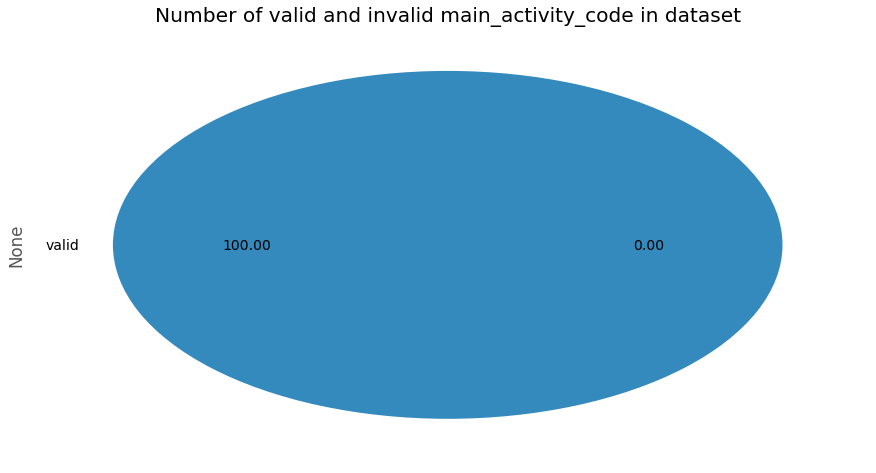

In [6]:
# count objects with invalid main_activity_code
d = dict()

invalid_main_activity = "0000000"
data_len = len(data)

d['valid'] = len(data[data.main_activity_code != invalid_main_activity]) / data_len * 100
d['invalid'] = len(data[data.main_activity_code == invalid_main_activity]) / data_len * 100

s = pd.Series(d)
s.plot(kind='pie', autopct='%.2f')
plt.title('Number of valid and invalid main_activity_code in dataset')

In [7]:
# remove items with invalid main_activity_code
data = data[data.main_activity_code != "0000000"]
print('dataset shape: {}.'.format(data.shape))

data.head(5)

dataset shape: (459018, 7).


,total_net_value,subquota_description,supplier,cnpj,main_activity_code,name,opening
0,3000.00,Publicity of parliamentary activity,Gráfica União,12341389000118,1813099,A. R. STRALIOTE - GRAFICA - ME,2010-03-08
1,140.00,Congressperson meal,CHURRASCARIA POTÊNCIA DO SUL LTDA,02454285000166,5611201,CHURRASCARIA POTENCIA DO SUL LTDA,1998-06-04
2,160.67,Fuels and lubricants,ITAPETRO COMBUSTÍVEIS,00214280000130,4731800,"ITAPETRO COMERCIO DE COMBUSTIVEIS, IMPORTACAO ...",1994-09-29
3,2600.00,Maintenance of office supporting parliamentary...,Locadora Gralha Azul Ltda,11071967000180,6810202,LOCADORA GRALHA AZUL LTDA - ME,2009-08-17
4,78.70,Fuels and lubricants,Auto Posto Tolecema Ltda,00564491000101,4731800,AUTO POSTO TOLECEMA LTDA,1995-04-19


In [8]:
labels = ['subquota_description', 'supplier', 'cnpj', 'name', 'main_activity_code']

df = data
for l in labels:
    df[l] = data[l].astype('category').cat.codes

df['opening'] = df.opening.astype(np.str).str.replace(r'\D+', '').astype('category').cat.codes

df.head()

,total_net_value,subquota_description,supplier,cnpj,main_activity_code,name,opening
0,3000.00,11,15492,19504,36,323,8410
1,140.00,2,8884,3543,238,8163,5486
2,160.67,5,17221,307,155,15517,4598
3,2600.00,7,19841,17979,301,17728,8270
4,78.70,5,5973,779,155,5307,4723


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

X = scale(df)

# # Benchmark clusters
X, _, = train_test_split(df, train_size=0.1, random_state=2)
X.shape

(45901, 7)

In [10]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(42 * '_')
print('init\t\ttime\tinertia\tsilhouette')

def bench_k_means(estimator, name, data, labels=0):
    t0 = time()
    estimator.fit(data)
    avg = metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=500)
    print('%-9s\t%.2fs\t%i\t%.3f' % (name, (time() - t0), estimator.inertia_, avg))

    
bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=10),
              name="KMeans (2)", data=X)
bench_k_means(KMeans(init='k-means++', n_clusters=20, n_init=10),
              name="KMeans (20)", data=X)
bench_k_means(KMeans(init='k-means++', n_clusters=200, n_init=10),
              name="KMeans (200)", data=X)
bench_k_means(KMeans(init='k-means++', n_clusters=2000, n_init=10),
              name="KMeans (2000)", data=X)

pca = PCA(n_components=1).fit_transform(X)
bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=10),
              name="PCA (2)", data=pca)
bench_k_means(KMeans(init='k-means++', n_clusters=20, n_init=10),
              name="PCA (20)", data=pca)
bench_k_means(KMeans(init='k-means++', n_clusters=200, n_init=10),
              name="PCA (200)", data=pca)
bench_k_means(KMeans(init='k-means++', n_clusters=2000, n_init=10),
              name="PCA (2000)", data=pca)

print(42 * '_')

__________________________________________
init		time	inertia	silhouette
KMeans (2)	0.28s	9636539198256	0.397
KMeans (20)	2.78s	1556555945314	0.313
KMeans (200)	25.30s	306017011517	0.365
KMeans (2000)	523.07s	33697236833	0.341
PCA (2)  	0.29s	1881361763667	0.672
PCA (20) 	1.12s	18379220497	0.582
PCA (200)	10.18s	142824700	0.581
PCA (2000)	151.05s	711357	0.341
__________________________________________


In [11]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=0.3).fit(X)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" %
      metrics.silhouette_score(X, db.labels_, metric='euclidean', sample_size=500))

Estimated number of clusters: 555
Silhouette Coefficient: -0.625
